/var/folders/c2/82qvf75162b67vqy5scm8x_r0000gn/T/ipykernel_64635/1262826680.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = read("input2.wav")


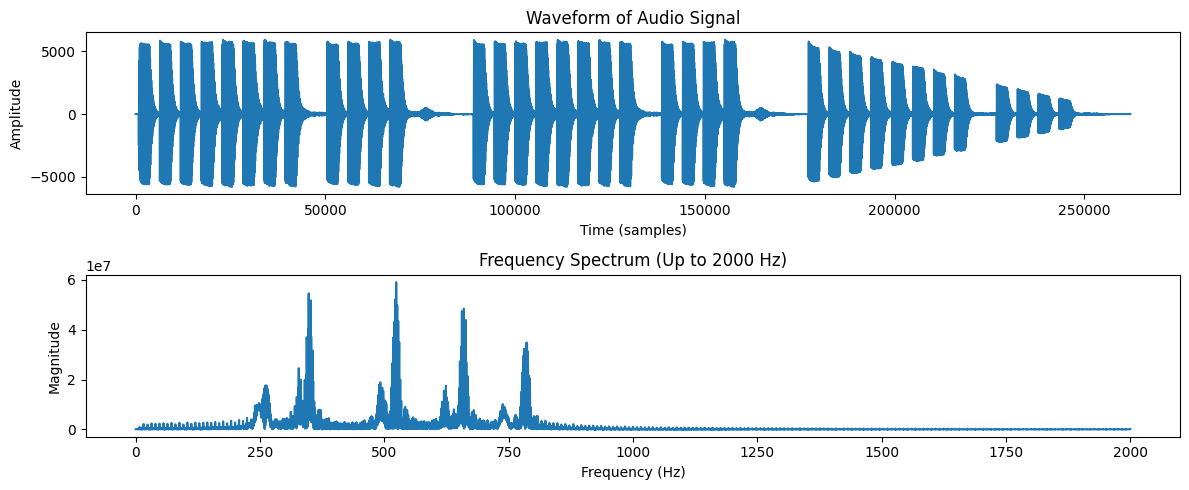

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

sample_rate, audio = read("input2.wav")

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = audio[:, 0]


#manually add noise

noise_intensity = 5000  
noise = np.random.normal(0, noise_intensity, audio.shape)

noisy_audio = np.int16(audio + noise)

write("noisy_audio.wav", sample_rate, noisy_audio)


N = len(audio)
audio_segment = audio[:N]

fft_result = fft(audio_segment)
frequencies = np.fft.fftfreq(N, d=1/sample_rate)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()


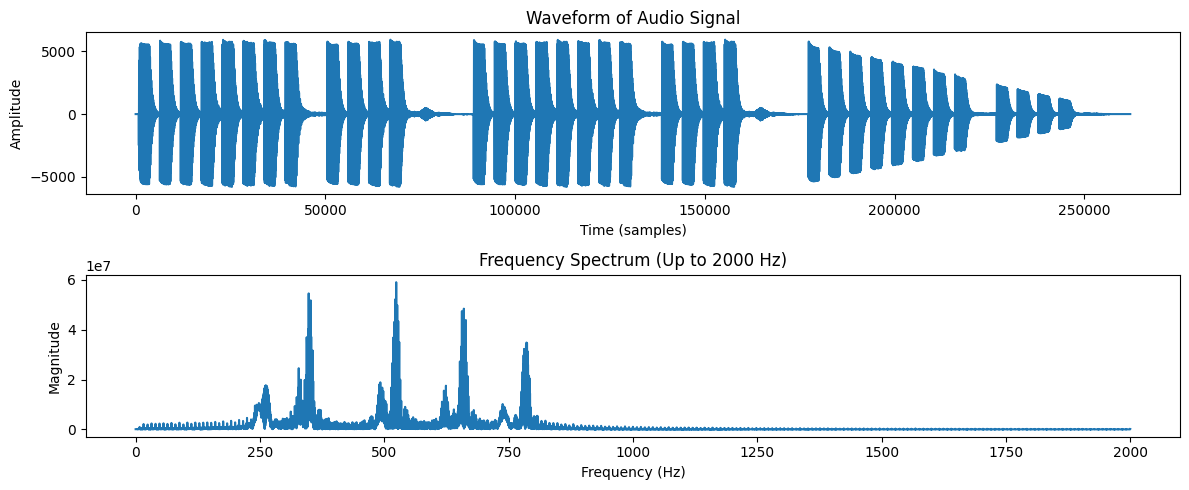

In [4]:
for i in range (0,N):
    if np.abs(fft_result[i]) < 10000:
        fft_result[i] = 0

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()



In [5]:
filtered_audio = np.int16(ifft(fft_result).real) 

output_filename = "filtered_audio.wav"
write(output_filename, sample_rate, filtered_audio)

In [6]:
fft_result = fft(filtered_audio)
frequencies = np.fft.fftfreq(N, d=1/sample_rate)

# Retune ratio (A440 to A415)
retune_ratio = 1/2 #double the frequencies

# New frequency bins after shifting
shifted_frequencies = frequencies * retune_ratio

# Interpolate FFT result to match new frequency bins
interp_func = interp1d(frequencies, fft_result, kind='linear', fill_value=0, bounds_error=False)
shifted_fft_result = interp_func(shifted_frequencies)


for i in range (0,N):
    if np.abs(shifted_fft_result[i]) < 1000:
        shifted_fft_result[i] = 0


retuned_audio = np.int16(ifft(shifted_fft_result).real)


output_filename = "retuned_audio.wav"
write(output_filename, sample_rate, retuned_audio)

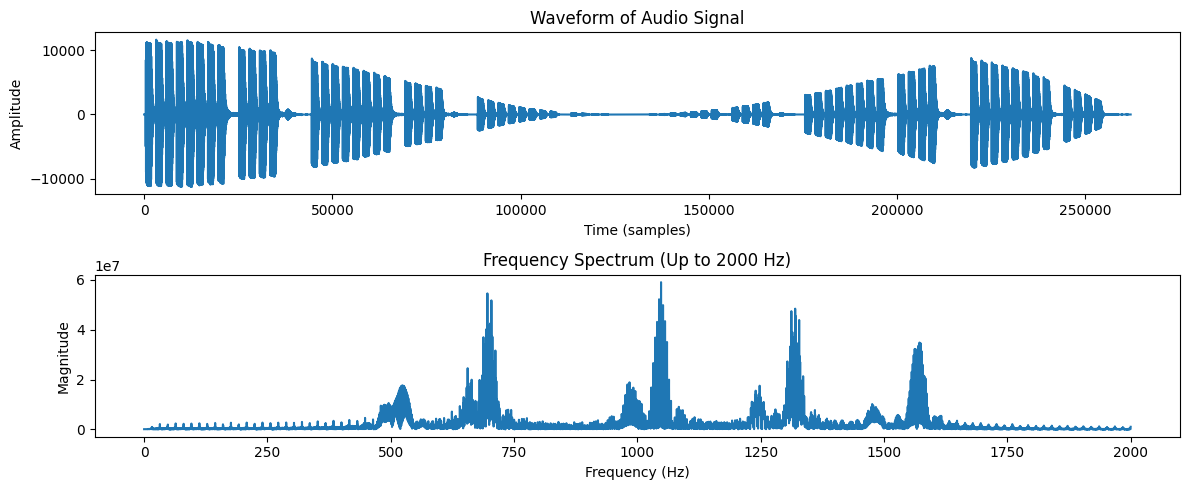

In [7]:
max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(retuned_audio)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(shifted_fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import math
from scipy.io.wavfile import read
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

In [ ]:
def load_and_normalize_audio(filename):
    """
    Load audio file and normalize the signal    
    Returns:
    tuple: (sample_rate, normalized_audio_data, normalization_factor, n_qubits)
    """
    sample_rate, audio = read(filename)
    
    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    # Get power of 2 samples for QFT
    n_samples = len(audio)
    n_qubits = int(np.ceil(np.log2(n_samples)))
    
    # Calculate resized length
    power_of_2_size = 2**n_qubits
    
    # Zero pad signal to reach the next power of 2
    if 2**n_qubits > n_samples:
        audio = np.pad(audio, (0, power_of_2_size - n_samples), 'constant')
    
    print(f"Original audio length: {n_samples}, Padded to: {power_of_2_size} (requires {n_qubits} qubits)")
    
    # Normalize the audio signal
    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, n_qubits

def prepare_quantum_state(normalized_audio, n_qubits):
    """
    Prepare a quantum state from normalized audio data and num qubits
    
    Returns:
    tuple: (quantum_circuit, number_of_qubits)
    """
    # Calculate number of qubits needed (log2 of audio samples)
    n_samples = len(normalized_audio)
    
    # Create quantum circuit
    qc = QuantumCircuit(n_qubits)
    
    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))
    
    return qc, n_qubits

/var/folders/c2/82qvf75162b67vqy5scm8x_r0000gn/T/ipykernel_64635/306996429.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = read(filename)


Original audio length: 262094, Padded to: 262144 (requires 18 qubits)
Number of qubits: 18
Sample rate: 44100 Hz
Normalized audio shape: (262144,)
Created quantum circuit with 18 qubits


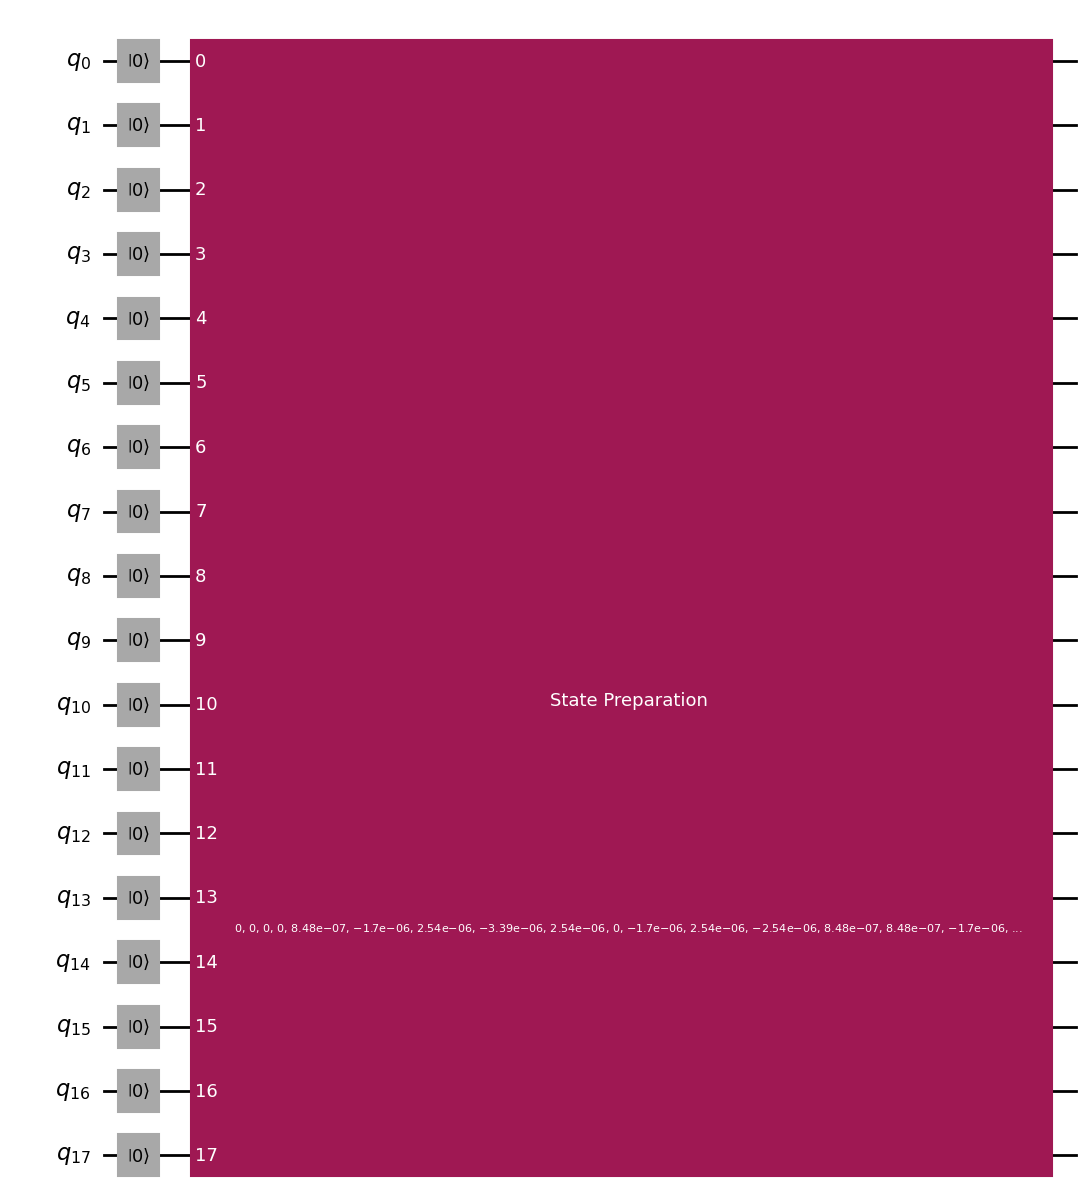

In [19]:
audio_file = "input2.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)
print(f"Number of qubits: {n_qubits}")
print(f"Sample rate: {sample_rate} Hz")
print(f"Normalized audio shape: {normalized_audio.shape}")

# Prepare quantum state
qc, n_qubits = prepare_quantum_state(normalized_audio, n_qubits)
print(f"Created quantum circuit with {n_qubits} qubits")

# Display the circuit
#print(qc)
qc.decompose().draw('mpl')